# Voice Emotion Prediction

## 1. Imports & Setup

In [47]:
import os
import torch
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns


**Explanation**
- `librosa` loads audio and resamples it.
- `Wav2Vec2FeatureExtractor` extracts raw audio features for the model.
- `LabelEncoder` encodes emotion labels as integers.
- `DataLoader` and `Dataset` handle batching.
- `tqdm` shows progress bars for training.

## 2. Collect Audio Files and Labels

In [48]:
DATA_DIR = "voice_emotion_project"

files = []
labels = []

# assuming subfolders are emotion labels
for label_name in os.listdir(DATA_DIR):
    label_path = os.path.join(DATA_DIR, label_name)
    if os.path.isdir(label_path):
        for f in os.listdir(label_path):
            if f.endswith(".wav"):
                files.append(os.path.join(label_path, f))
                labels.append(label_name)

print(f"Found {len(files)} audio files")
print("Example labels:", labels[:10])

Found 6325 audio files
Example labels: ['sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad']


## 3. Label Encoding & Train-Test Split

In [49]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
num_classes = len(le.classes_)
print("Classes:", le.classes_)

# Split train/test
train_files, test_files, train_labels, test_labels = train_test_split(
    files, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

Classes: ['angry' 'fear' 'happy' 'neutral' 'sad']


**Explanation:**
- Converts string labels into integer classes.
- Stratified split ensures all emotions are proportionally represented in train/test sets.

## 4. Device & Feature Extractor, Custom Dataset Class

In [50]:
# a. Device & Feature Extractor

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAMPLE_RATE = 16000  # Wav2Vec2 default

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    "facebook/wav2vec2-base"
)


# b. custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, file_paths, labels, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]

        # Load audio using librosa
        waveform, sr = librosa.load(path, sr=self.sample_rate)
        waveform = waveform.astype(np.float32)

        # Extract features
        inputs = bfeature_extractor(
            waveform,
            sampling_rate=self.sample_rate,
            return_tensors="pt",
            padding=True
        )
        input_values = inputs["input_values"].squeeze(0)
        return input_values, label

**Explanation for Device & Feature Extractor**:
- Moves model and data to GPU if available.
- Wav2Vec2 default sampling rate is 16kHz.
- feature_extractor prepares raw audio waveform for Wav2Vec2 input

**Explanation for Custom Dataset Class**:
- Loads each audio file and resamples to 16kHz.
- Converts waveform into a tensor suitable for Wav2Vec2.
- Returns (`input_values`, `label`) for training.

## 5. Collate Function for Batching

In [51]:
def collate_fn(batch):
    input_values = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])

    # Pad sequences to max length in batch
    input_values = torch.nn.utils.rnn.pad_sequence(
        input_values, batch_first=True, padding_value=0
    )
    return input_values, labels

**Explanation:**
- Pads variable-length audio sequences in a batch to the same length.
- Returns a batch tensor ready for model input

## 6. Prepare Dataloaders

In [52]:
BATCH_SIZE = 8

train_dataset = EmotionDataset(train_files, train_labels)
test_dataset = EmotionDataset(test_files, test_labels)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)


**Explanation**: 
- Creates PyTorch DataLoader objects for training/testing.
- `shuffle=True` ensures random batches during training.

## 7. Model Building

In [53]:
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=num_classes,
)
model.to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()


/home/cdsw/.local/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 7.1 Model Training

In [58]:
EPOCHS = 10  # increase for better accuracy
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for input_values, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_values = input_values.to(DEVICE)
        labels_batch = labels_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(input_values)
        logits = outputs.logits
        loss = criterion(logits, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * input_values.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for input_values, labels_batch in test_loader:
            input_values = input_values.to(DEVICE)
            labels_batch = labels_batch.to(DEVICE)
            outputs = model(input_values)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f} - Test Accuracy: {acc*100:.2f}%")


Epoch 1: 100%|██████████| 633/633 [05:40<00:00,  1.86it/s]


Epoch 1/10 - Loss: 0.3229 - Test Accuracy: 79.76%


Epoch 2: 100%|██████████| 633/633 [05:41<00:00,  1.85it/s]


Epoch 2/10 - Loss: 0.2648 - Test Accuracy: 77.23%


Epoch 3: 100%|██████████| 633/633 [05:41<00:00,  1.85it/s]


Epoch 3/10 - Loss: 0.2219 - Test Accuracy: 78.97%


Epoch 4: 100%|██████████| 633/633 [05:40<00:00,  1.86it/s]


Epoch 4/10 - Loss: 0.2056 - Test Accuracy: 76.68%


Epoch 5: 100%|██████████| 633/633 [05:40<00:00,  1.86it/s]


Epoch 5/10 - Loss: 0.1671 - Test Accuracy: 76.36%


Epoch 6: 100%|██████████| 633/633 [05:40<00:00,  1.86it/s]


Epoch 6/10 - Loss: 0.1519 - Test Accuracy: 78.89%


Epoch 7: 100%|██████████| 633/633 [05:41<00:00,  1.85it/s]


Epoch 7/10 - Loss: 0.1388 - Test Accuracy: 81.26%


Epoch 8: 100%|██████████| 633/633 [05:40<00:00,  1.86it/s]


Epoch 8/10 - Loss: 0.1285 - Test Accuracy: 81.19%


Epoch 9: 100%|██████████| 633/633 [05:41<00:00,  1.85it/s]


Epoch 9/10 - Loss: 0.0975 - Test Accuracy: 81.50%


Epoch 10: 100%|██████████| 633/633 [05:40<00:00,  1.86it/s]


Epoch 10/10 - Loss: 0.1050 - Test Accuracy: 81.19%


**Explanation**:
- Standard PyTorch training loop with forward/backward pass.
- After each epoch, evaluates test accuracy.
- `all_preds` and `all_labels` store results for metrics like confusion matrix.

### 7.2 Model Evaluation

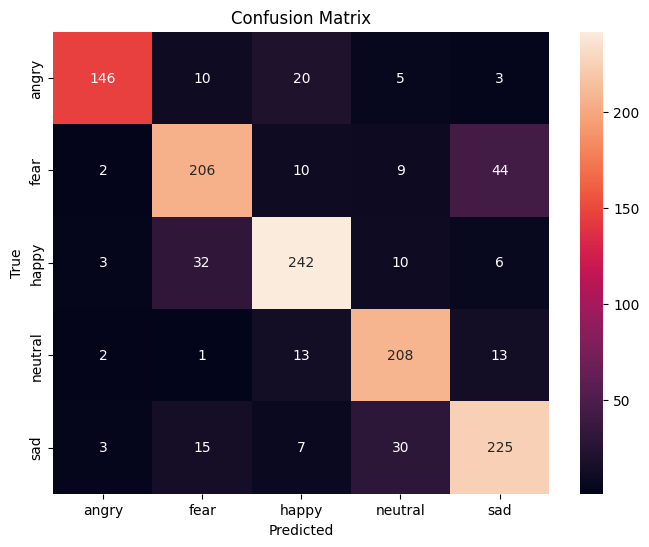

In [59]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [60]:
import torch
from sklearn.metrics import accuracy_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for input_values, labels_batch in test_loader:
        input_values = input_values.to(DEVICE)
        labels_batch = labels_batch.to(DEVICE)

        logits = model(input_values).logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 81.19%


## 8. Saving the Model

In [61]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

model.save_pretrained("emotion_model")
processor.save_pretrained("emotion_model")


[]

- This creates a folder emotion_model/ with all weights and config:
    - `config.json`
    - `model.safetensors`
    - `preprocessor_config.json`
    - `special_tokens_map.json`
    - `tokenizer_config.json`
    - `vocab.json`